In [31]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Import data and cleaning

In [32]:
df = pd.read_csv('sorting_event_volumes_2023.csv')

df['scanning_date'] = pd.to_datetime(df['scanning_date'], errors='coerce')
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.dayofweek + 1
df['week'] = df['scanning_date'].dt.isocalendar().week
df['week_of_month'] = (df['day'] - 1) // 7 + 1
df['yearday'] = df['scanning_date'].dt.dayofyear  # Voeg de dag van het jaar toe

# Data cleaning
print("Number of rows is: " + str(df.shape[0]))
df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df['scanning_date'] = pd.to_datetime(df['scanning_date'])
print("Number of rows cleaned data is: " + str(df.shape[0]))


Number of rows is: 8949721
Number of rows cleaned data is: 7450939


In [33]:
df_o = df

### Sum the number of events per day, per output belt, per sorting centre. Split on the differrent sorting centres

In [34]:
dfs = {name: group.groupby(['scanning_date', 'output_belt'], as_index=False)['no_of_events'].sum()
       .merge(group[['scanning_date', 'day', 'month', 'weekday', 'week', 'week_of_month','yearday']].drop_duplicates(), 
              on='scanning_date', how='left')
       for name, group in df.groupby('sorting_center_name')}

df_VANTAA, df_LIETO, df_TAMPERE, df_SEINÄJOKI, df_KUOPIO, df_OULU = [dfs[name] for name in ['VANTAA', 'LIETO', 'TAMPERE', 'SEINÄJOKI', 'KUOPIO', 'OULU']]

df = dfs['VANTAA']
df


,scanning_date,output_belt,no_of_events,day,month,weekday,week,week_of_month,yearday
0,2023-01-02,0,1,2,1,1,1,1,2
1,2023-01-02,1,533,2,1,1,1,1,2
2,2023-01-02,2,256,2,1,1,1,1,2
3,2023-01-02,3,1422,2,1,1,1,1,2
4,2023-01-02,4,1684,2,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...
44001,2023-12-30,96,956,30,12,6,52,5,364
44002,2023-12-30,97,692,30,12,6,52,5,364
44003,2023-12-30,98,929,30,12,6,52,5,364
44004,2023-12-30,99,47,30,12,6,52,5,364


### The following piece of codes adds events, with number of events = 0, since they are not in the data set

In [35]:
def fill_missing_events(df):
    all_dates = pd.date_range(start=df['scanning_date'].min(), end=df['scanning_date'].max())
    all_combinations = pd.MultiIndex.from_product([all_dates, df['output_belt'].unique()], names=['scanning_date', 'output_belt'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    df_filled = pd.merge(all_combinations_df, df, on=['scanning_date', 'output_belt'], how='left')
    df_filled['no_of_events'] = df_filled['no_of_events'].fillna(0)
    df_filled['day'] = df_filled['scanning_date'].dt.day
    df_filled['month'] = df_filled['scanning_date'].dt.month
    df_filled['weekday'] = df_filled['scanning_date'].dt.dayofweek + 1
    df_filled['week'] = df_filled['scanning_date'].dt.isocalendar().week
    df_filled['week_of_month'] = (df_filled['day'] - 1) // 7 + 1

    return df_filled
    
df_VANTAA = fill_missing_events(df_VANTAA)
df_LIETO = fill_missing_events(df_LIETO)
df_TAMPERE = fill_missing_events(df_TAMPERE)
df_SEINÄJOKI = fill_missing_events(df_SEINÄJOKI)
df_KUOPIO = fill_missing_events(df_KUOPIO)
df_OULU = fill_missing_events(df_OULU)


## Embeddings
#### Making a vector of all possible combinations, category_comb, and giving this a unique number category_encoded

In [36]:
df['category_comb'] = (
    df['output_belt'].astype(str) + '_' + 
    df['day'].astype(str) + '_' + 
    df['weekday'].astype(str) + '_' + 
    df['week_of_month'].astype(str)
)

# Encodeer de gecombineerde categorieën
df['category_encoded'] = df['category_comb'].astype('category').cat.codes
df


,scanning_date,output_belt,no_of_events,day,month,weekday,week,week_of_month,yearday,category_comb,category_encoded
0,2023-01-02,0,1,2,1,1,1,1,2,0_2_1_1,124
1,2023-01-02,1,533,2,1,1,1,1,2,1_2_1_1,2577
2,2023-01-02,2,256,2,1,1,1,1,2,2_2_1_1,4662
3,2023-01-02,3,1422,2,1,1,1,1,2,3_2_1_1,15237
4,2023-01-02,4,1684,2,1,1,1,1,2,4_2_1_1,17322
...,...,...,...,...,...,...,...,...,...,...,...
44001,2023-12-30,96,956,30,12,6,52,5,364,96_30_6_5,26278
44002,2023-12-30,97,692,30,12,6,52,5,364,97_30_6_5,26468
44003,2023-12-30,98,929,30,12,6,52,5,364,98_30_6_5,26657
44004,2023-12-30,99,47,30,12,6,52,5,364,99_30_6_5,26773


In [37]:
class EventDataset(Dataset):
    def __init__(self, df):
        self.data = df
        self.inputs = torch.tensor(self.data['category_encoded'].values, dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values, dtype=torch.float32)
        self.output_belt = torch.tensor(self.data['output_belt'].values, dtype=torch.long)
        self.yearday = torch.tensor(self.data['yearday'].values, dtype=torch.long)  # Voeg yearday toe

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.output_belt[idx], self.yearday[idx]

    def __len__(self):
        return len(self.data)

# Dataset splitsen
def split_dataset(df, method='sequential', test_size=0.25):
    if method == 'random':
        return train_test_split(df, test_size=test_size, random_state=42)
    else:  # 'sequential'
        split_idx = int((1 - test_size) * len(df))
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        return train_df, test_df

# Split de dataset
train_df, test_df = split_dataset(df)

# Initialiseer de dataloaders
train_loader = DataLoader(EventDataset(train_df), batch_size=512, shuffle=False)
test_loader = DataLoader(EventDataset(test_df), batch_size=512, shuffle=True)


In [38]:
class SimpleNN(nn.Module):
    def __init__(self, num_categories, embedding_dim):
        super(SimpleNN, self).__init__()
        self.embedding = nn.Embedding(num_categories, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        # print(x.shape)
        # print(x[0])
        x = self.embedding(x)
        x = self.bn1(torch.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(torch.relu(self.fc2(x)))
        x = self.bn3(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x


In [39]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=5, min_delta=0.01):
    train_losses, test_losses = [], []
    early_stopping_counter = 0  # Teller om het aantal niet-verbeterende epochs bij te houden

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # for inputs, targets, _ in train_loader:
        for inputs, targets, _, _ in train_loader:  # Voeg een extra underscore toe om yearday te negeren

            inputs = inputs.to(device)
            targets = targets.float().to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs).squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        avg_train_loss = running_loss / len(train_loader)
        # avg_train_loss = (running_loss / len(train_loader)) ** 0.5  # Vierkantswortel voor RMSE
        train_losses.append(avg_train_loss)
        
        # Evaluatie
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            # for inputs, targets, _ in test_loader:
            for inputs, targets, _, _ in test_loader:  # Voeg een extra underscore toe om yearday te negeren
                inputs = inputs.to(device)
                targets = targets.float().to(device)
                total_loss += criterion(model(inputs).squeeze(), targets).item()
        avg_test_loss = (total_loss / len(test_loader))
        # avg_test_loss = (total_loss / len(test_loader))**0.5 # Vierkantswortel voor RMSE
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early Stopping logica
        if epoch >= patience:
            if avg_test_loss > test_losses[-patience]:  # Vergelijk met de test loss van `patience` epochs geleden
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0  # Reset de teller als er verbetering is
        
            if early_stopping_counter >= patience:
                print(f'Early stopping na {epoch + 1} epochs.')
                break


    return train_losses, test_losses



Epoch [1/200], Train Loss: 887.1586, Test Loss: 901.2079, LR: 0.030000
Epoch [2/200], Train Loss: 699.3453, Test Loss: 768.6624, LR: 0.030000
Epoch [3/200], Train Loss: 606.4990, Test Loss: 713.2080, LR: 0.030000
Epoch [4/200], Train Loss: 501.9252, Test Loss: 658.7885, LR: 0.030000
Epoch [5/200], Train Loss: 457.8317, Test Loss: 645.4439, LR: 0.030000
Epoch [6/200], Train Loss: 427.0882, Test Loss: 619.4585, LR: 0.030000
Epoch [7/200], Train Loss: 390.8521, Test Loss: 558.2752, LR: 0.030000
Epoch [8/200], Train Loss: 353.1231, Test Loss: 531.7429, LR: 0.030000
Epoch [9/200], Train Loss: 326.2475, Test Loss: 522.7106, LR: 0.030000
Epoch [10/200], Train Loss: 311.1078, Test Loss: 514.6361, LR: 0.030000
Epoch [11/200], Train Loss: 297.8152, Test Loss: 507.9048, LR: 0.030000
Epoch [12/200], Train Loss: 285.5474, Test Loss: 501.9709, LR: 0.030000
Epoch [13/200], Train Loss: 278.9394, Test Loss: 495.6201, LR: 0.030000
Epoch [14/200], Train Loss: 270.0365, Test Loss: 498.4007, LR: 0.030000
E

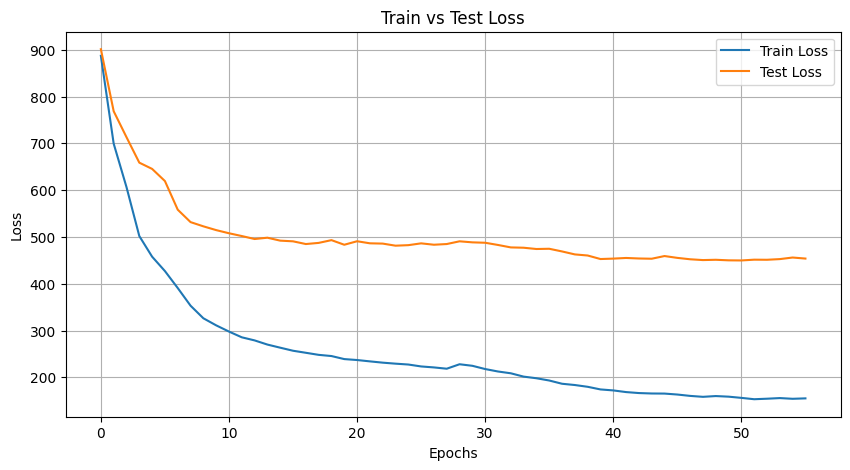

In [40]:
num_categories = len(df['category_encoded'].unique())
embedding_dim = 4

model = SimpleNN(num_categories=num_categories, embedding_dim=embedding_dim).to(device)
criterion = nn.L1Loss()
# criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.03)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=200)
plot_losses(train_losses, test_losses)

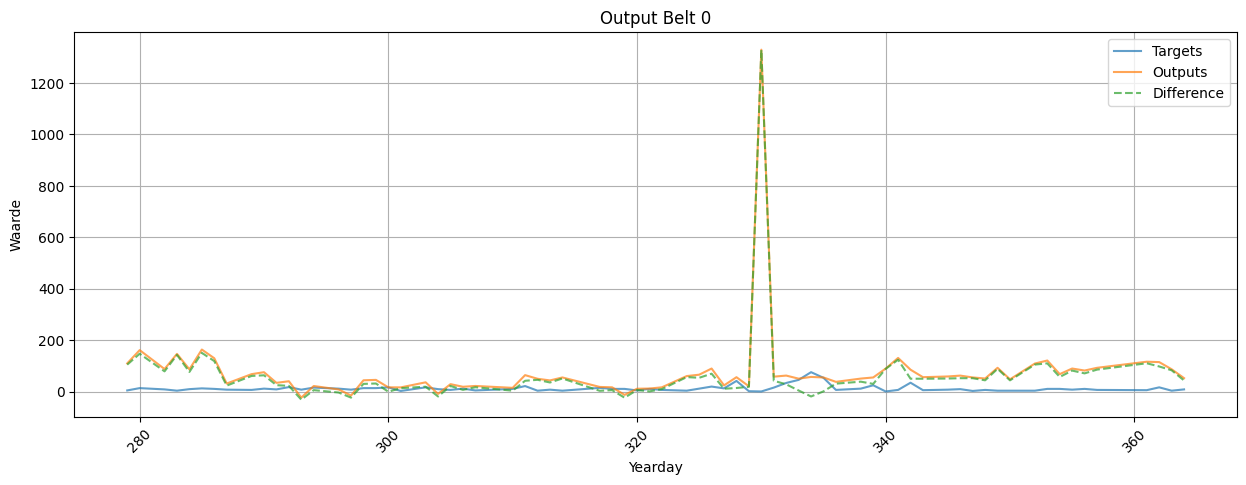

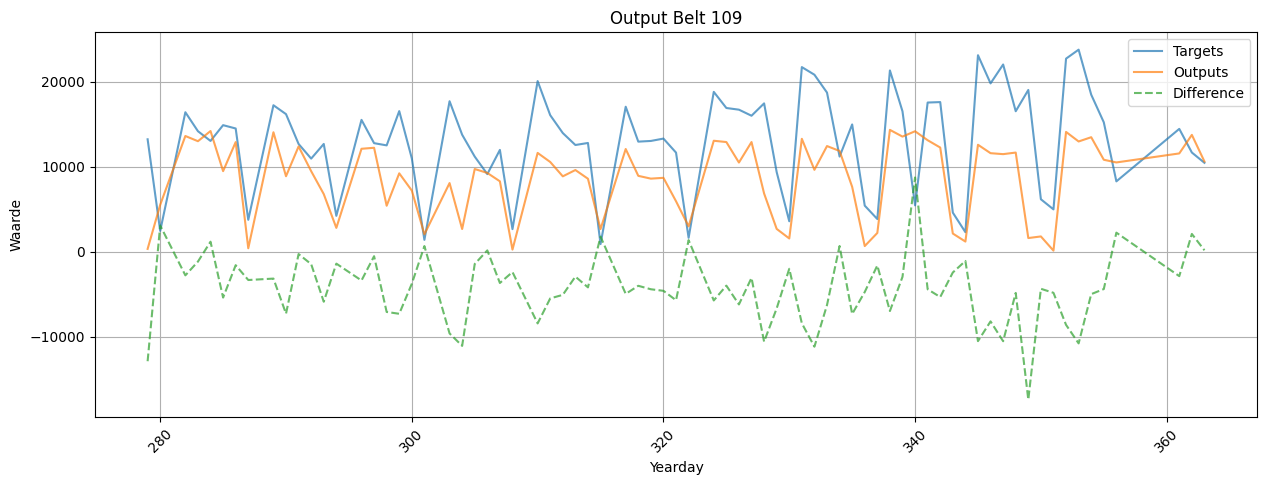

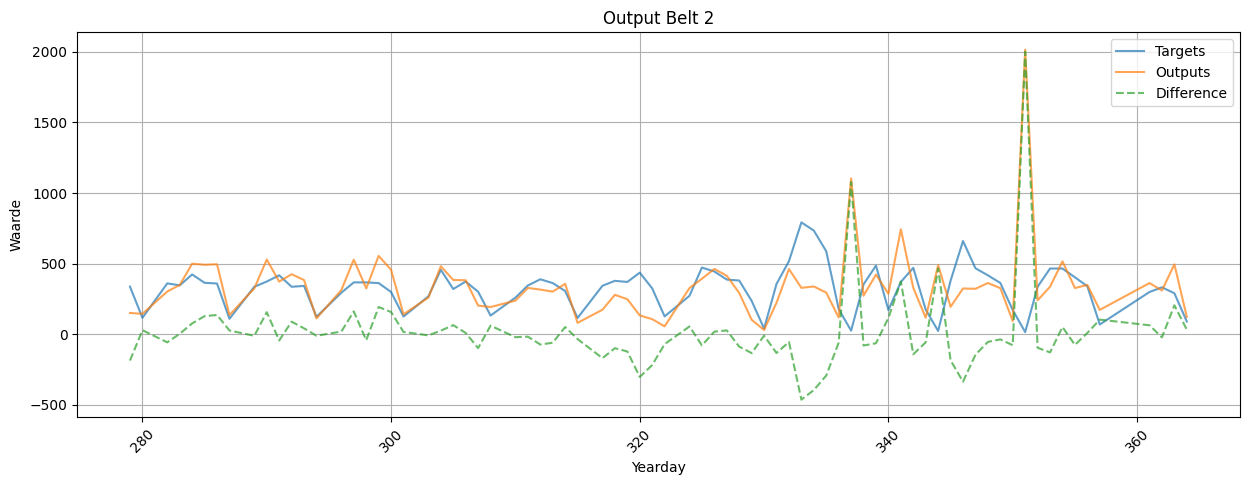

In [41]:
all_outputs, all_targets, all_output_belts, all_yeardays = [], [], [], []

for inputs, targets, output_belts, yearday in test_loader:
    inputs, targets = inputs.to(device), targets.float().to(device)
    all_outputs.append(model(inputs).squeeze().cpu().detach().numpy())
    all_targets.append(targets.cpu().numpy())
    all_output_belts.append(output_belts.cpu().numpy())
    all_yeardays.append(yearday.cpu().numpy())

all_outputs, all_targets, all_output_belts, all_yeardays = map(np.concatenate, (all_outputs, all_targets, all_output_belts, all_yeardays))

for belt in [0, 109, 2]:
    mask = all_output_belts == belt
    if mask.any():
        sort_idx = np.argsort(all_yeardays[mask])
        plt.figure(figsize=(15, 5))
        plt.plot(all_yeardays[mask][sort_idx], all_targets[mask][sort_idx], label='Targets', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx], label='Outputs', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx] - all_targets[mask][sort_idx], label='Difference', linestyle='--', alpha=0.7)
        plt.xlabel('Yearday')
        plt.ylabel('Waarde')
        plt.title(f'Output Belt {belt}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

## Model for all rural (so no VANTTAA)

In [42]:
# Voeg een unieke identifier toe aan de 'output_belt' voor elk sorting center
df_LIETO['output_belt'] = df_LIETO['output_belt'].astype(str) + '_LIETO'
df_TAMPERE['output_belt'] = df_TAMPERE['output_belt'].astype(str) + '_TAMPERE'
df_SEINÄJOKI['output_belt'] = df_SEINÄJOKI['output_belt'].astype(str) + '_SEINÄJOKI'
df_KUOPIO['output_belt'] = df_KUOPIO['output_belt'].astype(str) + '_KUOPIO'
df_OULU['output_belt'] = df_OULU['output_belt'].astype(str) + '_OULU'

# Voeg de dataframes samen (behalve df_VANTAA)
df_combined = pd.concat([df_LIETO, df_TAMPERE, df_SEINÄJOKI, df_KUOPIO, df_OULU], ignore_index=True)


In [43]:
df_combined

,scanning_date,output_belt,no_of_events,day,month,weekday,week,week_of_month,yearday
0,2023-01-01,0_LIETO,2.0,1,1,7,52,1,1.0
1,2023-01-01,101_LIETO,12.0,1,1,7,52,1,1.0
2,2023-01-01,102_LIETO,15.0,1,1,7,52,1,1.0
3,2023-01-01,103_LIETO,12.0,1,1,7,52,1,1.0
4,2023-01-01,104_LIETO,7.0,1,1,7,52,1,1.0
...,...,...,...,...,...,...,...,...,...
187161,2023-12-29,655_OULU,15.0,29,12,5,52,5,363.0
187162,2023-12-29,708_OULU,30.0,29,12,5,52,5,363.0
187163,2023-12-29,758_OULU,481.0,29,12,5,52,5,363.0
187164,2023-12-29,855_OULU,244.0,29,12,5,52,5,363.0


In [44]:
df_list = [df_LIETO, df_TAMPERE, df_SEINÄJOKI, df_KUOPIO, df_OULU]
for df, name in zip(df_list, ['LIETO', 'TAMPERE', 'SEINÄJOKI', 'KUOPIO', 'OULU']):
    df['output_belt'] = df['output_belt'].astype(str) + f'_{name}'
df_combined = pd.concat(df_list, ignore_index=True)
df_combined['output_belt_original'] = df_combined['output_belt']
df_combined['output_belt'] = pd.factorize(df_combined['output_belt'])[0]
df = df_combined

In [45]:
df['category_comb'] = (
    df['output_belt'].astype(str) + '_' + 
    df['day'].astype(str) + '_' + 
    df['weekday'].astype(str) + '_' + 
    df['week_of_month'].astype(str)
)

# Encodeer de gecombineerde categorieën
df['category_encoded'] = df['category_comb'].astype('category').cat.codes
df

,scanning_date,output_belt,no_of_events,day,month,weekday,week,week_of_month,yearday,output_belt_original,category_comb,category_encoded
0,2023-01-01,0,2.0,1,1,7,52,1,1.0,0_LIETO_LIETO,0_1_7_1,76
1,2023-01-01,1,12.0,1,1,7,52,1,1.0,101_LIETO_LIETO,1_1_7_1,23941
2,2023-01-01,2,15.0,1,1,7,52,1,1.0,102_LIETO_LIETO,2_1_7_1,47806
3,2023-01-01,3,12.0,1,1,7,52,1,1.0,103_LIETO_LIETO,3_1_7_1,71671
4,2023-01-01,4,7.0,1,1,7,52,1,1.0,104_LIETO_LIETO,4_1_7_1,95536
...,...,...,...,...,...,...,...,...,...,...,...,...
187161,2023-12-29,511,15.0,29,12,5,52,5,363.0,655_OULU_OULU,511_29_5_5,98399
187162,2023-12-29,512,30.0,29,12,5,52,5,363.0,708_OULU_OULU,512_29_5_5,98614
187163,2023-12-29,513,481.0,29,12,5,52,5,363.0,758_OULU_OULU,513_29_5_5,98829
187164,2023-12-29,514,244.0,29,12,5,52,5,363.0,855_OULU_OULU,514_29_5_5,99044


In [46]:
train_df, test_df = split_dataset(df)

train_loader = DataLoader(EventDataset(train_df), batch_size=4*512, shuffle=False)
test_loader = DataLoader(EventDataset(test_df), batch_size=4*512, shuffle=True)


In [47]:
for inputs, targets, _, _ in train_loader:
    print(f'inputs shape: {inputs.shape}, targets shape: {targets.shape}')


inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape: torch.Size([2048])
inputs shape: torch.Size([2048]), targets shape:

In [48]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=5, min_delta=0.01):
    train_losses, test_losses = [], []
    early_stopping_counter = 0  # Teller om het aantal niet-verbeterende epochs bij te houden

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # for inputs, targets, _ in train_loader:
        for inputs, targets, _, _ in train_loader:  # Voeg een extra underscore toe om yearday te negeren

            inputs = inputs.to(device)
            targets = targets.float().to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs).squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        avg_train_loss = running_loss / len(train_loader)
        # avg_train_loss = (running_loss / len(train_loader)) ** 0.5  # Vierkantswortel voor RMSE
        train_losses.append(avg_train_loss)
        
        # Evaluatie
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            # for inputs, targets, _ in test_loader:
            for inputs, targets, _, _ in test_loader:  # Voeg een extra underscore toe om yearday te negeren
                inputs = inputs.to(device)
                targets = targets.float().to(device)
                total_loss += criterion(model(inputs).squeeze(), targets).item()
        avg_test_loss = (total_loss / len(test_loader))
        # avg_test_loss = (total_loss / len(test_loader))**0.5 # Vierkantswortel voor RMSE
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early Stopping logica
        if epoch >= patience:
            if avg_test_loss > test_losses[-patience]:  # Vergelijk met de test loss van `patience` epochs geleden
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0  # Reset de teller als er verbetering is
        
            if early_stopping_counter >= patience:
                print(f'Early stopping na {epoch + 1} epochs.')
                break


    return train_losses, test_losses



Epoch [1/200], Train Loss: 213.3256, Test Loss: 149.6215, LR: 0.080000
Epoch [2/200], Train Loss: 163.3990, Test Loss: 151.6932, LR: 0.080000
Epoch [3/200], Train Loss: 144.3396, Test Loss: 152.5866, LR: 0.080000
Epoch [4/200], Train Loss: 130.0661, Test Loss: 143.6586, LR: 0.080000
Epoch [5/200], Train Loss: 119.8894, Test Loss: 147.2868, LR: 0.080000
Epoch [6/200], Train Loss: 113.4674, Test Loss: 145.5689, LR: 0.080000
Epoch [7/200], Train Loss: 107.1973, Test Loss: 143.2856, LR: 0.080000
Epoch [8/200], Train Loss: 104.3011, Test Loss: 142.3939, LR: 0.080000
Epoch [9/200], Train Loss: 102.4111, Test Loss: 141.3039, LR: 0.080000
Epoch [10/200], Train Loss: 100.9006, Test Loss: 140.7116, LR: 0.080000
Epoch [11/200], Train Loss: 99.6776, Test Loss: 140.6285, LR: 0.080000
Epoch [12/200], Train Loss: 98.1420, Test Loss: 140.0783, LR: 0.080000
Epoch [13/200], Train Loss: 97.0505, Test Loss: 139.9531, LR: 0.080000
Epoch [14/200], Train Loss: 95.6651, Test Loss: 139.8280, LR: 0.080000
Epoch

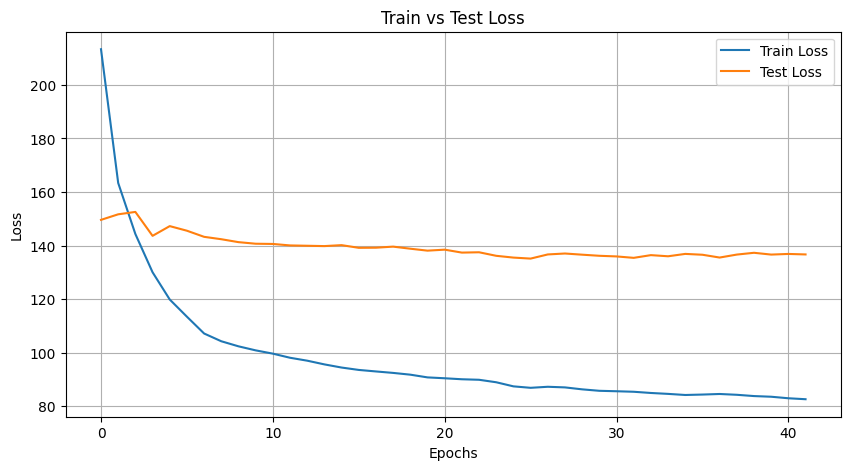

In [49]:
num_categories = len(df['category_encoded'].unique())
embedding_dim = 4

model = SimpleNN(num_categories=num_categories, embedding_dim=embedding_dim).to(device)
criterion = nn.L1Loss()
# criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.08)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=200)
plot_losses(train_losses, test_losses)

In [51]:
all_outputs, all_targets, all_output_belts, all_yeardays = [], [], [], []

for inputs, targets, output_belts, yearday in test_loader:
    inputs, targets = inputs.to(device), targets.float().to(device)
    all_outputs.append(model(inputs).squeeze().cpu().detach().numpy())
    all_targets.append(targets.cpu().numpy())
    all_output_belts.append(output_belts.cpu().numpy())
    all_yeardays.append(yearday.cpu().numpy())

all_outputs, all_targets, all_output_belts, all_yeardays = map(np.concatenate, (all_outputs, all_targets, all_output_belts, all_yeardays))

for belt in [1, 2,3 ]:
    mask = all_output_belts == belt
    if mask.any():
        sort_idx = np.argsort(all_yeardays[mask])
        plt.figure(figsize=(15, 5))
        plt.plot(all_yeardays[mask][sort_idx], all_targets[mask][sort_idx], label='Targets', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx], label='Outputs', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx] - all_targets[mask][sort_idx], label='Difference', linestyle='--', alpha=0.7)
        plt.xlabel('Yearday')
        plt.ylabel('Waarde')
        plt.title(f'Output Belt {belt}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

In [52]:
import numpy as np

# Selecteer willekeurig 10 unieke output_belts
unique_belts = np.unique(all_output_belts)
random_belts = np.random.choice(unique_belts, 10, replace=False)

all_outputs, all_targets, all_output_belts, all_yeardays = map(np.concatenate, (all_outputs, all_targets, all_output_belts, all_yeardays))

for belt in random_belts:
    mask = all_output_belts == belt
    if mask.any():
        sort_idx = np.argsort(all_yeardays[mask])
        plt.figure(figsize=(15, 5))
        plt.plot(all_yeardays[mask][sort_idx], all_targets[mask][sort_idx], label='Targets', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx], label='Outputs', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx] - all_targets[mask][sort_idx], label='Difference', linestyle='--', alpha=0.7)
        plt.xlabel('Yearday')
        plt.ylabel('Waarde')
        plt.title(f'Output Belt {belt}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()


ValueError: zero-dimensional arrays cannot be concatenated